In [ ]:
# load data
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# modelling
import statsmodels.formula.api as smf
import statsmodels.api as sm

# cross validation using statsmodel prepartion
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score, cross_validate, KFold

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [ ]:
def print_coef_std_err(results):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from statsmodel
    :return df: <pandas DataFrame>  combined estimated coefficient and standard error of model estimate
    """
    coef = results.params
    std_err = results.bse

    df = pd.DataFrame(data = np.transpose([coef, std_err]),
                      index = coef.index,
                      columns=["coef","std err"])
    return df

class StatsmodelsRegressor(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """

    def __init__(self, sm_class, sm_formula):
        self.sm_class = sm_class
        self.sm_formula = sm_formula
        self.model = None
        self.result = None

    def fit(self, data, dummy):
        self.model = self.sm_class(self.sm_formula, data)
        self.result = self.model.fit()

    def predict(self,X):
        return self.result.predict(X)

def kfold_split(data, n_fold):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from statsmodel
    :param n_fold: <int> Number of fold in k-fold CV
    :return df: <pandas DataFrame>  combined estimated coefficient and standard error of model estimate
    """
    kfold = KFold(n_splits = n_fold,
                  shuffle = True,
                  random_state=123)
    fold_train = {}
    fold_test = {}

    for i, (train, test) in enumerate(kfold.split(data)):
        print(f"fold {i+1}, train data rows: {len(train)}, test data rows: {len(test)}")
        fold_train[i] = data.iloc[train].copy()
        fold_test[i] = data.iloc[test].copy()

    return (fold_train, fold_test)

In [ ]:
df = pd.read_csv('Auto.csv')

In [ ]:
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
392,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
393,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
394,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
395,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


In [ ]:
#check is NaN
df.isna().sum()

,0
mpg,0
cylinders,0
displacement,0
horsepower,0
weight,0
acceleration,0
year,0
origin,0
name,0


In [ ]:
#check type data in dataframe
df.dtypes

,0
mpg,float64
cylinders,int64
displacement,float64
horsepower,object
weight,int64
acceleration,float64
year,int64
origin,int64
name,object


In [ ]:
#showing any string in horsepower column
df[~df['horsepower'].str.isnumeric()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
32,25.0,4,98.0,?,2046,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320,15.8,81,2,renault 18i


# **Handling Missing Values**

<ipython-input-10-3e77444d72cb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_edit['horsepower'] = pd.to_numeric(df_edit['horsepower'])


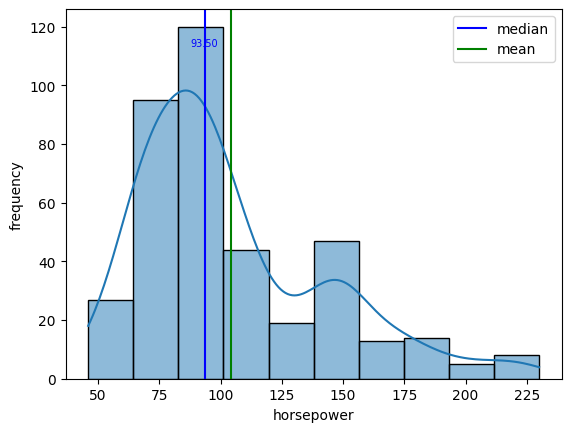

In [ ]:
#create new dataframe without the ? data in horsepower
df_edit = df[df['horsepower'] != '?']

#change housepower data into numeric
df_edit['horsepower'] = pd.to_numeric(df_edit['horsepower'])


#plot the histogram of horsepower data
sns.histplot(df_edit['horsepower'], bins = 10, kde = True)
plt.xlabel('horsepower')
plt.ylabel('frequency')

median = df_edit['horsepower'].median()
mean = df_edit['horsepower'].mean()

#add median and mean value in label
plt.axvline(x = median, color = 'blue', label = 'median')
plt.axvline(x = mean, color = 'green', label = 'mean')

# Display the labels on the plot
plt.text(median, plt.ylim()[1]*0.9, f'{median:.2f}', color='blue', size = 7, ha='center')

plt.legend()
plt.show()



In [ ]:
#change ?in horsepower to 93.5
df.loc[df['horsepower']=='?', 'horsepower'] = 93.5

#change horsepower into numeric
df['horsepower'] = pd.to_numeric(df['horsepower'])

In [ ]:
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
392,27.0,4,140.0,86.0,2790,15.6,82,1,ford mustang gl
393,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup
394,32.0,4,135.0,84.0,2295,11.6,82,1,dodge rampage
395,28.0,4,120.0,79.0,2625,18.6,82,1,ford ranger


In [ ]:
#change housepower into numeric
df['horsepower'] = pd.to_numeric(df['horsepower'])

In [ ]:
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
392,27.0,4,140.0,86.0,2790,15.6,82,1,ford mustang gl
393,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup
394,32.0,4,135.0,84.0,2295,11.6,82,1,dodge rampage
395,28.0,4,120.0,79.0,2625,18.6,82,1,ford ranger


#Exploratory Data Analytics: Plotting other variables against mpg

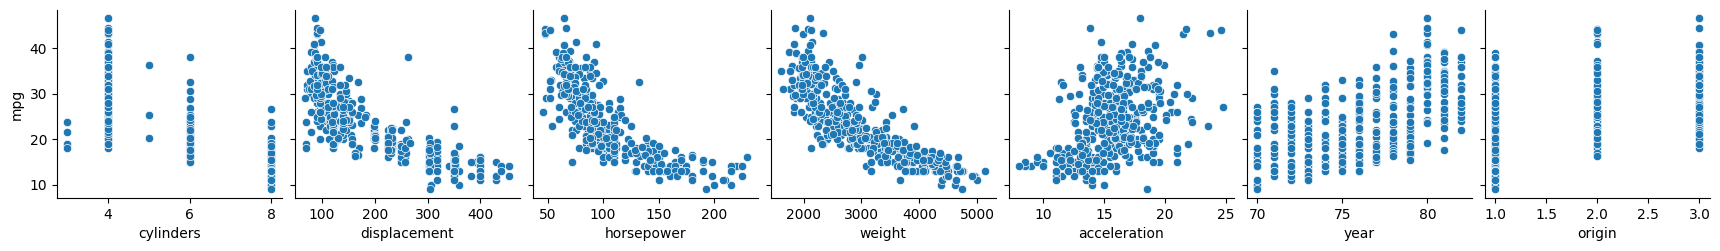

In [ ]:
#Plotting any predictors against mpg
sns.pairplot(data=df, x_vars=['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin'], y_vars = 'mpg')
plt.show()

**Pearson correlation**

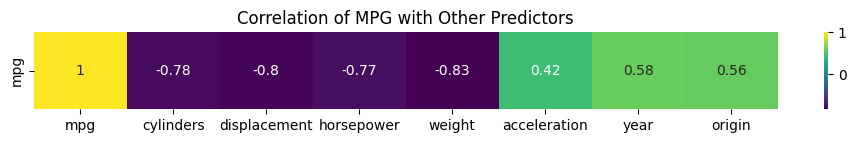

In [ ]:
#heatmap pearson correlation only for mpg to the predictors NOT predictors topredictors
cor = df[['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']].corr()
mpg_cor = cor[['mpg']].transpose()

# Set the custom width and height before creating the heatmap
fig, ax = plt.subplots(figsize=(12, 1))

# Plot the heatmap
sns.heatmap(mpg_cor, annot=True, cmap='viridis', cbar=True, ax=ax)

plt.title("Correlation of MPG with Other Predictors")
plt.show()

# **Building MODEL FOR PREDICTING MPG **

## Model 1

In [ ]:
#building the data using library smf

model_1 = smf.ols(formula = 'mpg ~ cylinders +	displacement +	horsepower + weight + acceleration + year +origin	', data = df)
result_1 = model_1.fit()

In [ ]:
#calling the data using function print_coef_std_err that we have defined
print_coef_std_err(result_1)

,coef,std err
Intercept,-18.474039,4.620862
cylinders,-0.449834,0.322549
displacement,0.019183,0.007510
horsepower,-0.011008,0.013501
weight,-0.006698,0.000643
acceleration,0.110836,0.097471
year,0.761082,0.050634
origin,1.405731,0.276014


STD ERROR PER COEF MODEL 1

In [ ]:
std_per_coef_model_1 = print_coef_std_err(result_1)
std_per_coef_model_1['std_err_per_coef'] = (std_per_coef_model_1['std err'] / std_per_coef_model_1['coef'])*100
std_per_coef_model_1

,coef,std err,std_err_per_coef
Intercept,-18.474039,4.620862,-25.012730
cylinders,-0.449834,0.322549,-71.704061
displacement,0.019183,0.007510,39.145998
horsepower,-0.011008,0.013501,-122.652459
weight,-0.006698,0.000643,-9.605770
acceleration,0.110836,0.097471,87.941856
year,0.761082,0.050634,6.652879
origin,1.405731,0.276014,19.634900


In [ ]:
print(result_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     256.1
Date:                Sat, 02 Nov 2024   Prob (F-statistic):          2.22e-141
Time:                        07:35:06   Log-Likelihood:                -1037.3
No. Observations:                 397   AIC:                             2091.
Df Residuals:                     389   BIC:                             2123.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -18.4740      4.621     -3.998   

In [ ]:
#R2 result
result_1.rsquared

0.8217011201126686

In [ ]:
# Create a class model
ols_all_media = StatsmodelsRegressor(smf.ols,  'mpg ~ cylinders + log_displacement + log_horsepower + log_weight + log_acceleration + year + origin')

K-FOLD MODEL 1

In [ ]:
# Create a class model
ols_all_media = StatsmodelsRegressor(smf.ols,  'mpg ~ cylinders +	displacement +	horsepower + weight + acceleration + year +origin	')

In [ ]:
#creating k-fold splitter object
kfold = KFold(n_splits=5, shuffle = True, random_state=123)

In [ ]:
scores_ols_all_media = cross_val_score(estimator = ols_all_media,
                                       X = df,
                                       y = df["mpg"],
                                       cv = kfold,
                                       scoring = "r2")
scores_ols_all_media = pd.DataFrame(data = scores_ols_all_media,
                                    columns=["test_rsquared"])
scores_ols_all_media["folds"] = [f"Folds {i+1}" for i in range(5)]
scores_ols_all_media

,test_rsquared,folds
0,0.792021,Folds 1
1,0.798420,Folds 2
2,0.818475,Folds 3
3,0.840893,Folds 4
4,0.801044,Folds 5


In [ ]:
scores_ols_all_media["test_rsquared"].mean()

0.8101704718217226

Compared with baseline (prediction using the average value of the target), does the model outperforms the baseline?

In [ ]:
#calculate baseline predictions (average profit)
y = df["mpg"].values
baseline_predictions = np.mean(y)

#generating prediction using the baseline
baseline_predictions = np.repeat(baseline_predictions, len(y))

#calculating MSE for baseline
baseline_mse = mean_squared_error(y, baseline_predictions)
baseline_mse

61.088942128939344

In [ ]:
model = LinearRegression()
mse_list = []

In [ ]:
X = df.drop(columns= ['mpg','name'])
y = df["mpg"]

In [ ]:
for train_index, test_index in kfold .split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for this fold and store it
    mse_list.append(mean_squared_error(y_test, y_pred))
# Calculate average MSE across all folds
average_mse = np.mean(mse_list)

In [ ]:
average_mse

11.549115128009452

Residual Plot

Text(0, 0.5, 'Residuals')

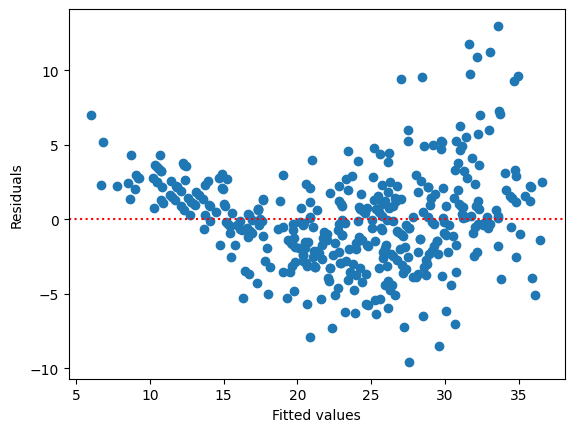

In [ ]:
residuals = result_1.resid
plt.scatter(result_1.fittedvalues, residuals)
plt.axhline(y = 0, color = 'r', linestyle = 'dotted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

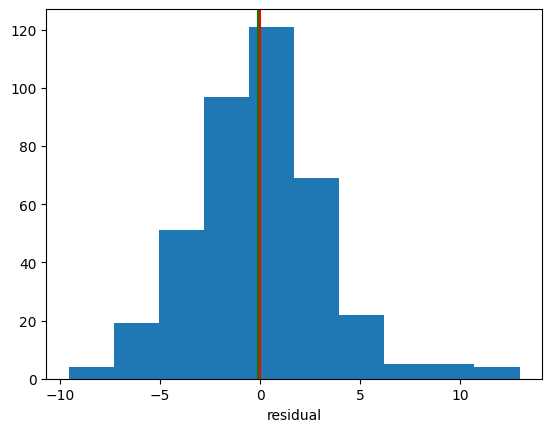

In [ ]:
#histogram of residual
plt.hist(result_1.resid)
plt.xlabel('residual')
plt.axvline(x = result_1.resid.mean(), color = 'red')
plt.axvline(x = result_1.resid.median(), color = 'green')

Predictors and Y ('mpg') Transformation

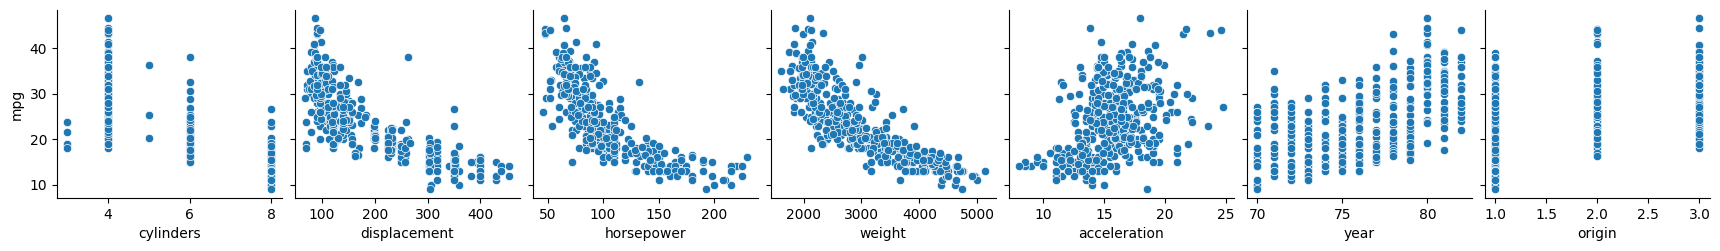

In [ ]:
sns.pairplot(data=df, x_vars=['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin'], y_vars = 'mpg')
plt.show()

In [ ]:
df['log_displacement'] = np.log(df['displacement'])
df['log_horsepower'] = np.log(df['horsepower'])
df['log_weight'] = np.log(df['weight'])
df['log_acceleration'] = np.log(df['acceleration'])

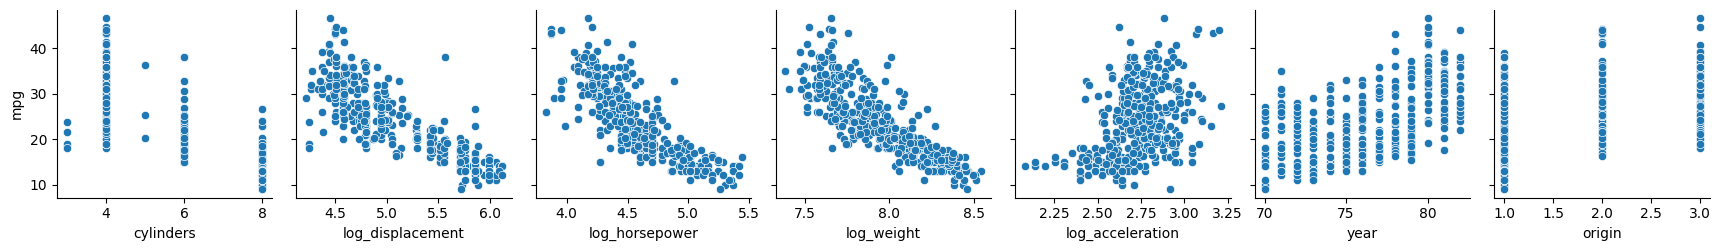

In [ ]:
#plot the transformed predictors with mpg
sns.pairplot(data=df, x_vars=['cylinders', 'log_displacement', 'log_horsepower', 'log_weight', 'log_acceleration', 'year', 'origin'], y_vars = 'mpg')
plt.show()

##Model 2

In [ ]:
#building the data using library smf
model_2 = smf.ols(formula = 'mpg ~ cylinders +	log_displacement +	log_horsepower + log_weight + log_acceleration + year +origin	', data = df)
result_2 = model_2.fit()

In [ ]:
#find coefficient correlation
print_coef_std_err(result_2)

,coef,std err
Intercept,118.560054,9.993098
cylinders,0.484605,0.283928
log_displacement,-1.889837,1.421201
log_horsepower,-5.873870,1.488926
log_weight,-13.539752,2.144270
log_acceleration,-3.969690,1.552174
year,0.741244,0.046351
origin,0.743911,0.276238


In [ ]:
result_2.rsquared

0.8491896491554977

STD ERROR PER COEF MODEL 2

In [ ]:
std_per_coef_model_2 = print_coef_std_err(result_2)
std_per_coef_model_2['std_err_per_coef'] = (std_per_coef_model_2['std err'] / std_per_coef_model_2['coef'])*100
std_per_coef_model_2

,coef,std err,std_err_per_coef
Intercept,118.560054,9.993098,8.428722
cylinders,0.484605,0.283928,58.589595
log_displacement,-1.889837,1.421201,-75.202275
log_horsepower,-5.873870,1.488926,-25.348302
log_weight,-13.539752,2.144270,-15.836849
log_acceleration,-3.969690,1.552174,-39.100627
year,0.741244,0.046351,6.253131
origin,0.743911,0.276238,37.133151


In [ ]:
print(result_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     312.9
Date:                Sat, 02 Nov 2024   Prob (F-statistic):          1.73e-155
Time:                        07:35:11   Log-Likelihood:                -1004.1
No. Observations:                 397   AIC:                             2024.
Df Residuals:                     389   BIC:                             2056.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          118.5601      9.993  

In [ ]:
#kfold for result_2
ols_all_media_result_2 = StatsmodelsRegressor(smf.ols,  'mpg ~ cylinders +	log_displacement +	log_horsepower + log_weight + log_acceleration + year +origin	')
#creating k-fold splitter object
kfold = KFold(n_splits=5, shuffle = True, random_state=123)

In [ ]:
scores_ols_all_media = cross_val_score(estimator =ols_all_media_result_2,
                                       X = df,
                                       y = df["mpg"],
                                       cv = kfold,
                                       scoring = "r2")
scores_ols_all_media = pd.DataFrame(data = scores_ols_all_media,
                                    columns=["test_rsquared"])
scores_ols_all_media["folds"] = [f"Folds {i+1}" for i in range(5)]
scores_ols_all_media

,test_rsquared,folds
0,0.837797,Folds 1
1,0.800060,Folds 2
2,0.858996,Folds 3
3,0.868261,Folds 4
4,0.837700,Folds 5


In [ ]:
scores_ols_all_media['test_rsquared'].mean()

0.8405626628629695

Residual Plot for last model (No collinearity, taking out log cylinders and log displacement)

Text(0, 0.5, 'Residuals')

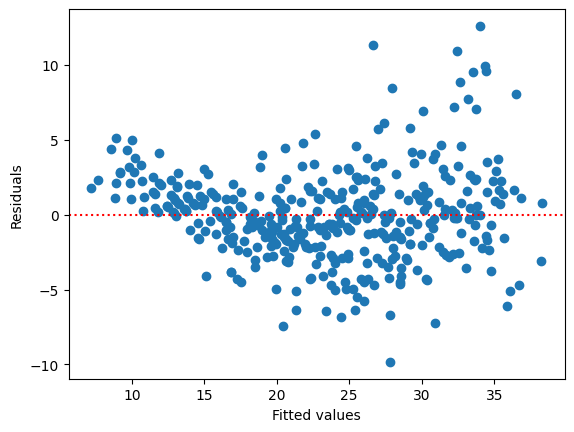

In [ ]:
plt.scatter(result_2.fittedvalues, result_2.resid)
plt.axhline(y = 0, color = 'r', linestyle = 'dotted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

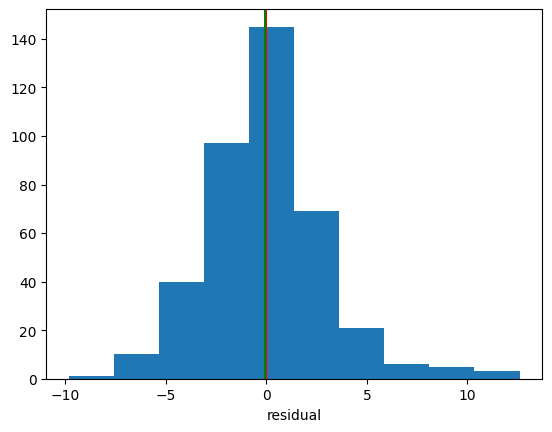

In [ ]:
#histogram of residual
plt.hist(result_2.resid)
plt.xlabel('residual')
plt.axvline(x = result_2.resid.mean(), color = 'red')
plt.axvline(x = result_2.resid.median(), color = 'green')

still shows heteroscedasticity

## MODEL 3

In [ ]:
#create new model where we use log(mpg) instead of only mpg
df['log_mpg'] = np.log(df['mpg'])

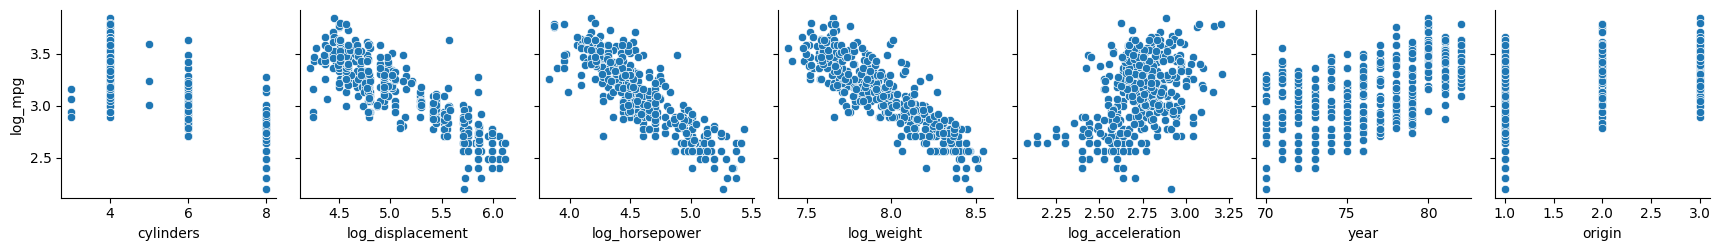

In [ ]:
sns.pairplot(data=df, x_vars=['cylinders', 'log_displacement', 'log_horsepower', 'log_weight', 'log_acceleration', 'year', 'origin'], y_vars = 'log_mpg')
plt.show()

In [ ]:
#create new model where we use log(mpg) instead of only mpg
model_3 = smf.ols(formula = 'log_mpg ~ cylinders +	log_displacement +	log_horsepower + log_weight + log_acceleration + year +origin	', data = df)
result_3 = model_3.fit()

In [ ]:
#find coefficient correlation
print_coef_std_err(result_3)

,coef,std err
Intercept,7.249331,0.369090
cylinders,-0.012303,0.010487
log_displacement,-0.012402,0.052491
log_horsepower,-0.255695,0.054993
log_weight,-0.594374,0.079197
log_acceleration,-0.154081,0.057329
year,0.029903,0.001712
origin,0.020839,0.010203


In [ ]:
result_3.rsquared

0.8910596310130257

In [ ]:
std_per_coef_model_3 = print_coef_std_err(result_3)
std_per_coef_model_3['std_err_per_coef'] = (std_per_coef_model_3['std err'] / std_per_coef_model_3['coef'])*100
std_per_coef_model_3

,coef,std err,std_err_per_coef
Intercept,7.249331,0.369090,5.091361
cylinders,-0.012303,0.010487,-85.234230
log_displacement,-0.012402,0.052491,-423.263931
log_horsepower,-0.255695,0.054993,-21.507132
log_weight,-0.594374,0.079197,-13.324504
log_acceleration,-0.154081,0.057329,-37.206898
year,0.029903,0.001712,5.724940
origin,0.020839,0.010203,48.960501


In [ ]:
print(result_3.summary())

                            OLS Regression Results                            
Dep. Variable:                log_mpg   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     454.5
Date:                Sat, 02 Nov 2024   Prob (F-statistic):          6.59e-183
Time:                        07:35:13   Log-Likelihood:                 305.44
No. Observations:                 397   AIC:                            -594.9
Df Residuals:                     389   BIC:                            -563.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.2493      0.369  

In [ ]:
#kfold for result_3
ols_all_media_result_3 = StatsmodelsRegressor(smf.ols,  'log_mpg ~ cylinders +	log_displacement +	log_horsepower + log_weight + log_acceleration + year +origin	')

In [ ]:
#creating k-fold splitter object
kfold = KFold(n_splits=5, shuffle = True, random_state=123)

In [ ]:
scores_ols_all_media = cross_val_score(estimator =ols_all_media_result_3,
                                       X = df,
                                       y = df["log_mpg"],
                                       cv = kfold,
                                       scoring = "r2")
scores_ols_all_media = pd.DataFrame(data = scores_ols_all_media,
                                    columns=["test_rsquared"])
scores_ols_all_media["folds"] = [f"Folds {i+1}" for i in range(5)]
scores_ols_all_media

,test_rsquared,folds
0,0.885572,Folds 1
1,0.849323,Folds 2
2,0.882369,Folds 3
3,0.914207,Folds 4
4,0.888930,Folds 5


In [ ]:
scores_ols_all_media['test_rsquared'].mean()

0.8840804351851876

Residual value of latest model:

Text(0, 0.5, 'Residuals')

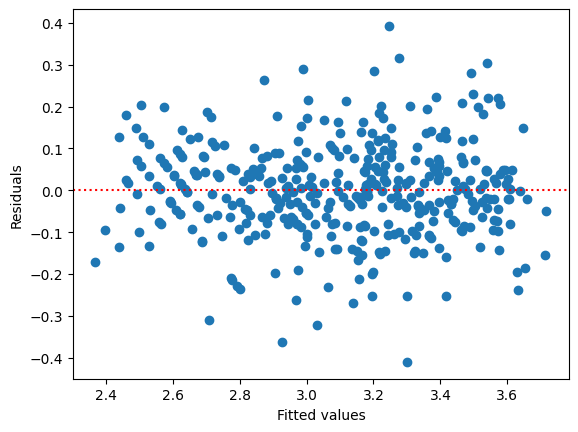

In [ ]:
plt.scatter(result_3.fittedvalues, result_3.resid)
plt.axhline(y = 0, color = 'r', linestyle = 'dotted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

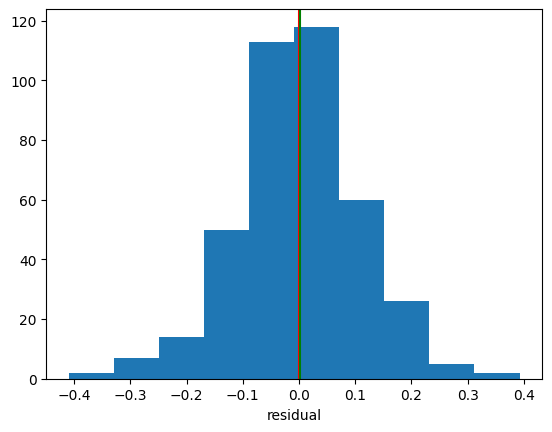

In [ ]:
plt.hist(result_3.resid)
plt.xlabel('residual')
plt.axvline(x = result_3.resid.mean(), color = 'red')
plt.axvline(x = result_3.resid.median(), color = 'green')

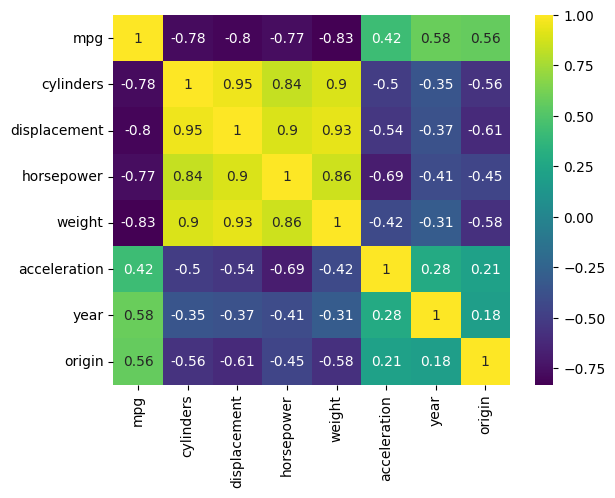

In [ ]:
sns.heatmap(df[['mpg','cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']].corr(), annot=True, cmap='viridis')
plt.show()

## MODEL 4

In [ ]:
#create new model where we use log(mpg) same as model 3, but only use log_weight and log_horsepower

model_4 = smf.ols(formula = 'log_mpg ~ log_horsepower + log_weight + log_acceleration + year +origin	', data = df)
result_4 = model_4.fit()

In [ ]:
print_coef_std_err(result_4)

,coef,std err
Intercept,7.603553,0.307931
log_horsepower,-0.259045,0.055013
log_weight,-0.665894,0.054817
log_acceleration,-0.130848,0.054871
year,0.030319,0.001699
origin,0.023703,0.009013


In [ ]:
result_4.rsquared

0.8901445009547815

In [ ]:
std_per_coef_model_4 = print_coef_std_err(result_4)
std_per_coef_model_4['std_err_per_coef'] = (std_per_coef_model_4['std err'] / std_per_coef_model_4['coef'])*100
std_per_coef_model_4

,coef,std err,std_err_per_coef
Intercept,7.603553,0.307931,4.049827
log_horsepower,-0.259045,0.055013,-21.237012
log_weight,-0.665894,0.054817,-8.232116
log_acceleration,-0.130848,0.054871,-41.935248
year,0.030319,0.001699,5.603376
origin,0.023703,0.009013,38.024572


In [ ]:
#kfold for result_4
ols_all_media_result_4 = StatsmodelsRegressor(smf.ols,  'log_mpg ~ log_horsepower + log_weight + log_acceleration + year +origin')

In [ ]:
#creating k-fold splitter object
kfold = KFold(n_splits=5, shuffle = True, random_state=123)

In [ ]:
scores_ols_all_media = cross_val_score(estimator =ols_all_media_result_4,
                                       X = df,
                                       y = df["log_mpg"],
                                       cv = kfold,
                                       scoring = "r2")
scores_ols_all_media = pd.DataFrame(data = scores_ols_all_media,
                                    columns=["test_rsquared"])
scores_ols_all_media["folds"] = [f"Folds {i+1}" for i in range(5)]
scores_ols_all_media

,test_rsquared,folds
0,0.884976,Folds 1
1,0.847892,Folds 2
2,0.879845,Folds 3
3,0.914301,Folds 4
4,0.893039,Folds 5


In [ ]:
scores_ols_all_media['test_rsquared'].mean()

0.884010577181342

Residual value

Text(0, 0.5, 'Residuals')

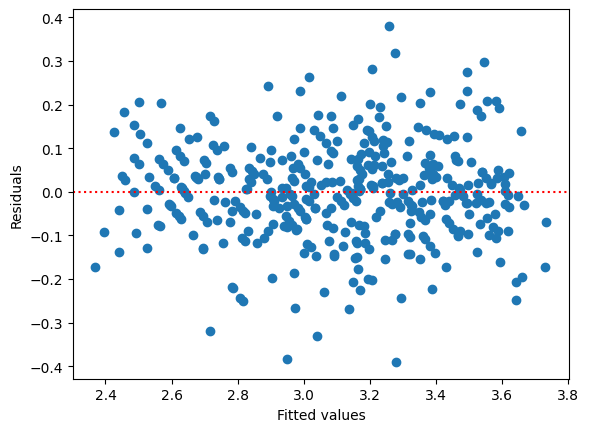

In [ ]:
plt.scatter(result_4.fittedvalues, result_4.resid)
plt.axhline(y = 0, color = 'r', linestyle = 'dotted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

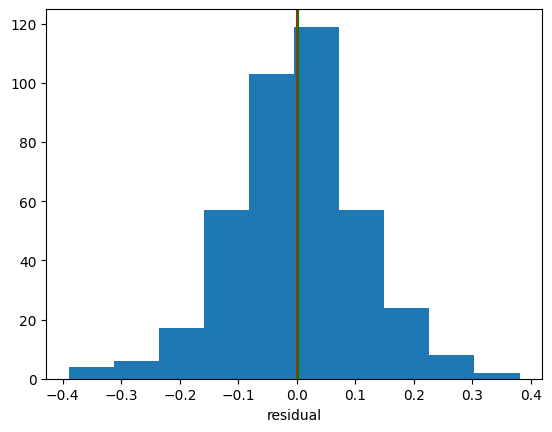

In [ ]:
plt.hist(result_4.resid)
plt.xlabel('residual')
plt.axvline(x = result_4.resid.mean(), color = 'red')
plt.axvline(x = result_4.resid.median(), color = 'green')